## Clustering - Decision Tree (outlier)

- Cluster the unlabelled data with kmeans clustering
- We assign the label to each sample, making it a supervised learning task
- We train a Decision Tree model
- Inspect the Decision Tree’s output to quantitatively highlight the characteristics of the cluster

In [2]:
import pandas as pd


from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


In [3]:
# We will be using not normalised data without outliers
df_without_outlier = pd.read_csv('new_df_outliers_only_copy_smote_resampled_noNormalised.csv')

# Convert age and bmi to int type
df_without_outlier['bmi'] = df_without_outlier['bmi'].round().astype(int)
df_without_outlier['age'] = df_without_outlier['age'].round().astype(int)

df_without_outlier

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,smoking_history_encoded,gender_encoded,diabetes
0,54,0,0,55,6.000000,100,0.310171,-0.310005,0
1,34,0,0,56,6.200000,200,-0.052540,-0.310005,0
2,67,0,0,63,8.800000,155,-0.052540,-0.310005,1
3,38,0,0,56,6.500000,130,-0.052540,0.561670,0
4,30,0,0,50,6.000000,100,-0.273853,-0.310005,0
...,...,...,...,...,...,...,...,...,...
6163,59,0,0,48,5.914183,158,-0.052540,-0.310005,0
6164,36,0,0,48,4.800000,127,-0.182851,-0.310005,0
6165,16,0,0,51,6.213743,82,-0.179245,-0.310005,0
6166,40,0,0,51,6.401829,155,-0.200757,-0.022104,0


In [6]:
# Features
X_outlier = df_without_outlier.drop('diabetes', axis=1)

X_outlier

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,smoking_history_encoded,gender_encoded
0,54,0,0,55,6.000000,100,0.310171,-0.310005
1,34,0,0,56,6.200000,200,-0.052540,-0.310005
2,67,0,0,63,8.800000,155,-0.052540,-0.310005
3,38,0,0,56,6.500000,130,-0.052540,0.561670
4,30,0,0,50,6.000000,100,-0.273853,-0.310005
...,...,...,...,...,...,...,...,...
6163,59,0,0,48,5.914183,158,-0.052540,-0.310005
6164,36,0,0,48,4.800000,127,-0.182851,-0.310005
6165,16,0,0,51,6.213743,82,-0.179245,-0.310005
6166,40,0,0,51,6.401829,155,-0.200757,-0.022104


Best Hyperparameters for K-means, Decision Tree

NameError: name 'np' is not defined

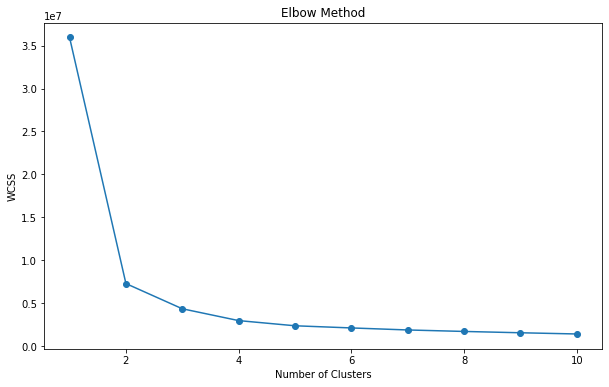

In [16]:
# Fit KMeans clustering models for different number of clusters
wcss = []
max_clusters = 10  # Maximum number of clusters to try
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_outlier)
    wcss.append(kmeans.inertia_)

# Plot WCSS vs. Number of Clusters
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='-')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(np.arange(1, max_clusters + 1))
plt.grid(True)
plt.show()

- Select the value of k at the “elbow” ie the point after which the distortion/inertia starts decreasing in a linear fashion. 
- Hence, the optimal number of clusters for the data is 3.

In [9]:
# Define hyperparameters grid for tuning
param_grid = {
    'max_depth': [3, 5, 7, None],
    'criterion': ['gini', 'entropy'],
}

# Create a decision tree classifier
dtree = DecisionTreeClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_outlier, [1] * len(X_outlier))  # Assigning all instances to a single class for clustering

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 3}


In [17]:
# Perform K-means clustering
k = 3 # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(X_outlier)

In [18]:
X_with_cluster_labels = X_outlier.copy()  # Make a copy of X_without_outlier
X_with_cluster_labels['Cluster Label'] = cluster_labels

In [19]:
# Step 4: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_outlier, cluster_labels, test_size=0.2, random_state=42)

# Train Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42, criterion = 'gini', max_depth = 3)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

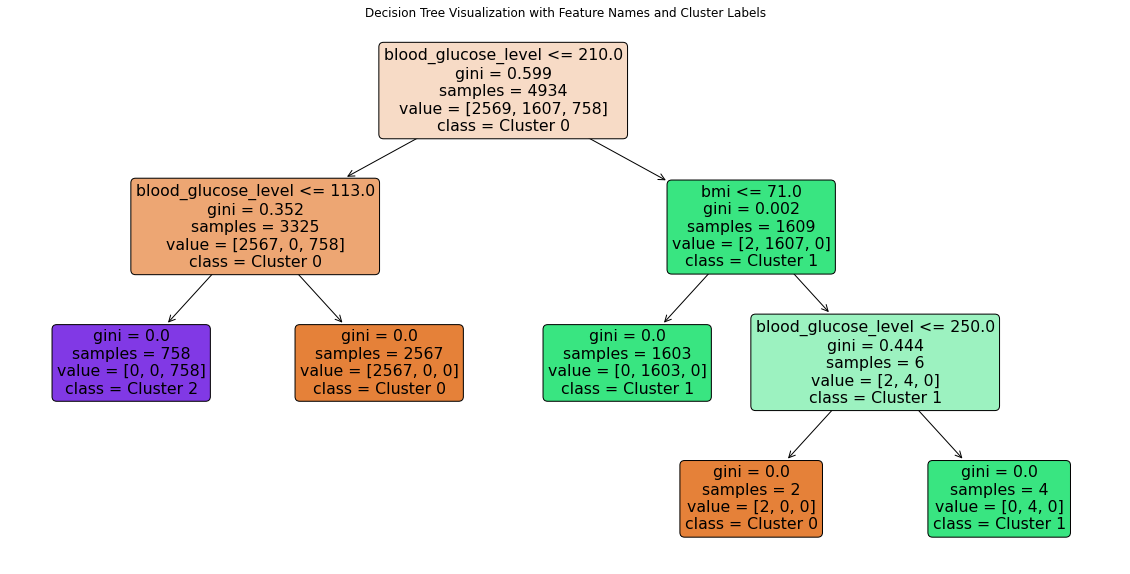

In [21]:
# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt_classifier, filled=True, feature_names=X_outlier.columns.tolist(), class_names=['Cluster 0', 'Cluster 1', 'Cluster 2'], rounded=True)
plt.title("Decision Tree Visualization with Feature Names and Cluster Labels")
plt.show()

- For Decision Tree, only blood glucose level and bmi is used out of 8 features. 
- This might be due to KMeans clustering generates cluster labels for the data, effectively reducing the dimensionality of the data.

In [22]:
# Step 6: Predict the cluster labels for test set
y_pred = dt_classifier.predict(X_test)

Evaluation using the silhouette score
- Sihouette score ranges from -1 to 1, where a high value indicates that the clusters are well-separated and cohesive. 
- Scores above 0.5 suggest good clustering, below 0.25 indicate poor clustering, and between 0.25 and 0.5 denote fair clustering. 

In [23]:
silhouette_avg = silhouette_score(X_test, y_pred)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.5604416759929727
